In [1]:
import sys
sys.path.append('..') 
from helper_fun import *
from tqdm import tqdm
import seaborn as sns
import umap
import sklearn.datasets
import sklearn.cluster as cluster
import hdbscan
import plotly.express as px
from time import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

# from sklearn.decomposition import PCA
# from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
SEED = 42
seed_everything(SEED)

#adapted from OPIG website
def fingerprint_list_from_smiles_list(smiles_list, n_bits=2048):
    fingerprint_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fingerprint_list.append(fingerprint_as_array(mol, n_bits))
    return fingerprint_list

def fingerprint_as_array(mol, n_bits=2048):
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    array = np.zeros((1,), int)
    DataStructs.ConvertToNumpyArray(fingerprint, array)
    return array

def get_umap_fingerprint_array(table, smiles_column="SMILES"):
    SMILES_list = [x for x in table[smiles_column]]
    fingerprint_list = fingerprint_list_from_smiles_list(SMILES_list)
    fingerprint_array = np.array(fingerprint_list) 
    return fingerprint_array

def get_umap_fingerprint_array_fig(table, CID_column="CID", pIC50_column="f_avg_pIC50", smiles_column="SMILES"):
    fingerprint_array = get_umap_fingerprint_array(table, smiles_column=smiles_column)
    umap_reducer = umap.UMAP()
    umap_fingerprint_array = umap_reducer.fit_transform(fingerprint_array)
    umap_fingerprint_array_fig = pd.DataFrame(umap_fingerprint_array, columns=["X","Y"])
    umap_fingerprint_array_fig[CID_column] = table[CID_column].values
    umap_fingerprint_array_fig[pIC50_column] = table[pIC50_column].values
    umap_fingerprint_array_fig[smiles_column] = table[smiles_column].values
    umap_fingerprint_array_fig.dropna(subset=[CID_column], inplace=True)
    return umap_fingerprint_array_fig

def get_umap_fingerprint_plot(table, CID_column="CID", pIC50_column="f_avg_pIC50"):
    umap_fingerprint_array_fig = get_umap_fingerprint_array_fig(table, CID_column="CID", pIC50_column="f_avg_pIC50")
    custom_data = umap_fingerprint_array_fig[[CID_column, pIC50_column]]

    df_fig = px.scatter(umap_fingerprint_array_fig, x="X", y="Y",
                    hover_data= [CID_column, pIC50_column],
                    custom_data= custom_data,
                    title="UMAP Projection of Molecules")

    df_fig.update_traces(hovertemplate='CID: %{customdata[0]}<br>f_avg_pIC50: %{customdata[1]}')
    df_fig.update_layout(width=800, height=800, transition_duration=500)

    return df_fig.show()


2024-07-30 11:50:35.633154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Enhanced clustering

  0%|          | 0/595 [00:00<?, ?it/s][11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPRECATION WARNING: please use MorganGenerator
[11:50:43] DEPREC

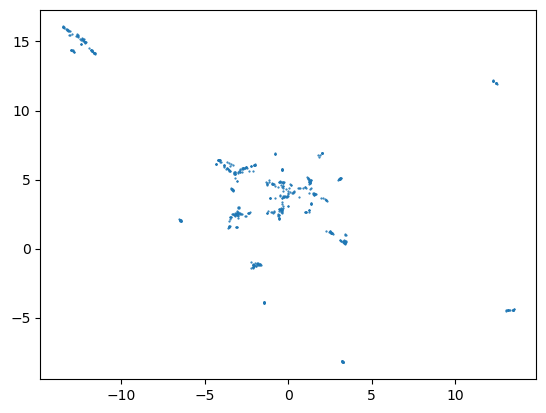

In [2]:
compounds = pd.read_csv("../COVID_MOONSHOT/compounds_filtered.csv")
fingerprint_array = get_umap_fingerprint_array(compounds, smiles_column="SMILES")
umap_fingerprint_array_fig = get_umap_fingerprint_array_fig(compounds, CID_column="CID", pIC50_column="f_avg_pIC50")
clusterable_embedding = umap.UMAP(
    n_neighbors=15,
    min_dist=0.0,
    n_components=2,
).fit_transform(fingerprint_array)

plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.3);

In [3]:
clusterer = hdbscan.HDBSCAN(min_samples=15, min_cluster_size=75)
labels = clusterer.fit_predict(clusterable_embedding)


main_cluster = np.argmax(np.bincount(labels[labels >= 0]))
main_cluster_centroid = clusterable_embedding[labels == main_cluster].mean(axis=0)
distances = []
for i in np.unique(labels):
    if i == main_cluster or i == -1:  # Exclude noise (-1) and the main cluster
        continue
    cluster_centroid = clusterable_embedding[labels == i].mean(axis=0)
    distance = np.linalg.norm(cluster_centroid - main_cluster_centroid)
    distances.append((i, distance))

distances.sort(key=lambda x: x[1], reverse=True)
furthest_cluster_label = distances[0][0]
furthest_cluster_points = clusterable_embedding[labels == furthest_cluster_label]

#select a subset of the furthest cluster points
if len(furthest_cluster_points) > len(clusterable_embedding) * 0.2:
    _, distances_to_centroid = pairwise_distances_argmin_min(furthest_cluster_points, [clusterable_embedding[labels == furthest_cluster_label].mean(axis=0)])
    selected_indices = np.argsort(distances_to_centroid)[-int(len(clusterable_embedding) * 0.2):]
    selected_points = furthest_cluster_points[selected_indices]
else:
    selected_points = furthest_cluster_points

#gives a 114 points (20% = 119) !
noise_points = clusterable_embedding[labels == -1]

print(f"Number of selected points: {len(selected_points)}")
print(f"Number of noise points: {len(noise_points)}")   



Number of selected points: 79
Number of noise points: 14


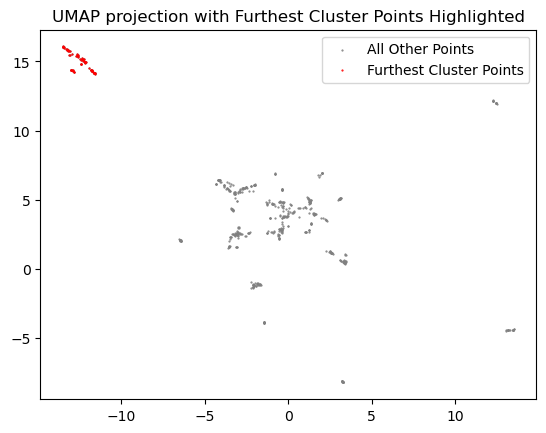

In [4]:

# Plot all points
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], color='gray', s = 0.3, label='All Other Points')

# Highlight selected points
plt.scatter(selected_points[:, 0], selected_points[:, 1], color='red', s= 0.3, label='Furthest Cluster Points')

plt.legend()
plt.title('UMAP projection with Furthest Cluster Points Highlighted')
plt.show()

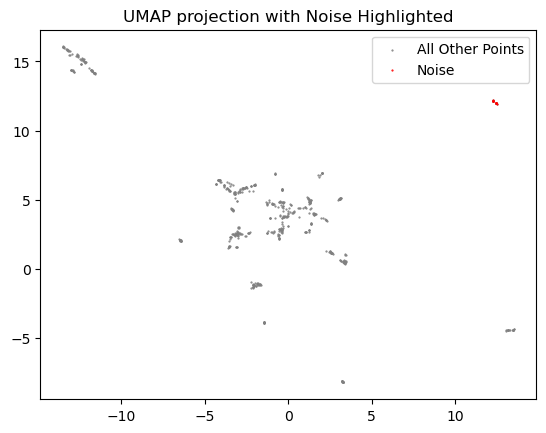

In [5]:
# Plot all points
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], color='gray', s = 0.3, label='All Other Points')

# Highlight selected points
plt.scatter(noise_points[:, 0], noise_points[:, 1], color='red', s= 0.3, label='Noise')

plt.legend()
plt.title('UMAP projection with Noise Highlighted')
plt.show()

In [6]:
#create a numpy.ndarray of points from clusterable_embedding not in selected_points
mask1 = np.ones(len(clusterable_embedding), dtype=bool)
mask2 = np.ones(len(clusterable_embedding), dtype=bool)

# Iterate over selected points and update the mask to False for selected points
for point in selected_points:
    # Find the indices where the points match the selected point
    indices = np.where((clusterable_embedding == point).all(axis=1))[0]
    # Set those positions in the mask to False (indicating they are selected, not non-selected)
    mask1[indices] = False
for point in noise_points:
    # Find the indices where the points match the selected point
    indices = np.where((clusterable_embedding == point).all(axis=1))[0]
    # Set those positions in the mask to False (indicating they are selected, not non-selected)
    mask2[indices] = False

# Use the mask to filter out the selected points, leaving only non-selected points
non_selected_points = clusterable_embedding[mask1]
non_noise_points = clusterable_embedding[mask2]

In [7]:
#turn selected_points into two pd.Series
selected_points_series_x = pd.Series(selected_points[:, 0])  # For the first column
selected_points_series_y = pd.Series(selected_points[:, 1])
clusterable_embedding_series_x = pd.Series(clusterable_embedding[:, 0])
clusterable_embedding_series_y = pd.Series(clusterable_embedding[:, 1])

selected_points_series_x.name = "selected_X"
selected_points_series_y.name = "selected_Y"
clusterable_embedding_series_x.name = "cluster_X"
clusterable_embedding_series_y.name = "cluster_Y"

cluster_embedding_df0 = pd.merge(clusterable_embedding_series_x, clusterable_embedding_series_y, left_index=True, right_index=True)
cluster_embedding_df = pd.merge(cluster_embedding_df0, umap_fingerprint_array_fig, left_index=True, right_index=True)
selected_points_merge = pd.merge(selected_points_series_x, selected_points_series_y, left_index=True, right_index=True)
selected_points_df = pd.merge(selected_points_merge, cluster_embedding_df, left_on=["selected_X", "selected_Y"], right_on=["cluster_X", "cluster_Y"])


#     # Append these rows to the selected_points_df DataFrame
#     selected_points_df = pd.concat([selected_points_df, matching_rows], ignore_index=True)
X_test = selected_points_df["SMILES"].apply(smiles_to_fp)
Y_test = selected_points_df["f_avg_pIC50"]


In [8]:
non_selected_points_series_x = pd.Series(non_selected_points[:, 0])  # For the first column
non_selected_points_series_y = pd.Series(non_selected_points[:, 1])

non_selected_points_series_x.name = "non_selected_X"
non_selected_points_series_y.name = "non_selected_Y"


non_selected_points_merge = pd.merge(non_selected_points_series_x, non_selected_points_series_y, left_index=True, right_index=True)
selected_points_df = pd.merge(non_selected_points_merge, cluster_embedding_df, left_on=["non_selected_X", "non_selected_Y"], right_on=["cluster_X", "cluster_Y"])


#     # Append these rows to the selected_points_df DataFrame
#     selected_points_df = pd.concat([selected_points_df, matching_rows], ignore_index=True)
X_train = selected_points_df["SMILES"].apply(smiles_to_fp)
Y_train = selected_points_df["f_avg_pIC50"]
# print(X_train.shape)

In [9]:
def furthest_cluster_split(table, smiles_column="SMILES", CID_column="CID", pIC50_column="f_avg_pIC50"):
    fingerprint_array = get_umap_fingerprint_array(table, smiles_column=smiles_column)
    umap_fingerprint_array_fig = get_umap_fingerprint_array_fig(table, CID_column=CID_column, pIC50_column=pIC50_column)
    clusterable_embedding = umap.UMAP(n_neighbors=15, min_dist=0.0, n_components=2,).fit_transform(fingerprint_array)
    clusterer = hdbscan.HDBSCAN(min_samples=15, min_cluster_size=75)
    labels = clusterer.fit_predict(clusterable_embedding)


    main_cluster = np.argmax(np.bincount(labels[labels >= 0]))
    main_cluster_centroid = clusterable_embedding[labels == main_cluster].mean(axis=0)
    distances = []
    for i in np.unique(labels):
        if i == main_cluster or i == -1:  # Exclude noise (-1) and the main cluster
            continue
        cluster_centroid = clusterable_embedding[labels == i].mean(axis=0)
        distance = np.linalg.norm(cluster_centroid - main_cluster_centroid)
        distances.append((i, distance))

    distances.sort(key=lambda x: x[1], reverse=True)
    furthest_cluster_label = distances[0][0]
    furthest_cluster_points = clusterable_embedding[labels == furthest_cluster_label]

    #select a subset of the furthest cluster points
    if len(furthest_cluster_points) > len(clusterable_embedding) * 0.2:
        _, distances_to_centroid = pairwise_distances_argmin_min(furthest_cluster_points, [clusterable_embedding[labels == furthest_cluster_label].mean(axis=0)])
        selected_indices = np.argsort(distances_to_centroid)[-int(len(clusterable_embedding) * 0.2):]
        selected_points = furthest_cluster_points[selected_indices]
    else:
        selected_points = furthest_cluster_points

        #create a numpy.ndarray of points from clusterable_embedding not in selected_points
    mask1 = np.ones(len(clusterable_embedding), dtype=bool)


    # Iterate over selected points and update the mask to False for selected points
    for point in selected_points:
        # Find the indices where the points match the selected point
        indices = np.where((clusterable_embedding == point).all(axis=1))[0]
        # Set those positions in the mask to False (indicating they are selected, not non-selected)
        mask1[indices] = False

    # Use the mask to filter out the selected points, leaving only non-selected points
    non_selected_points = clusterable_embedding[mask1]

    #turn selected_points into two pd.Series
    selected_points_series_x = pd.Series(selected_points[:, 0])  # For the first column
    selected_points_series_y = pd.Series(selected_points[:, 1])
    clusterable_embedding_series_x = pd.Series(clusterable_embedding[:, 0])
    clusterable_embedding_series_y = pd.Series(clusterable_embedding[:, 1])

    selected_points_series_x.name = "selected_X"
    selected_points_series_y.name = "selected_Y"
    clusterable_embedding_series_x.name = "cluster_X"
    clusterable_embedding_series_y.name = "cluster_Y"

    cluster_embedding_df0 = pd.merge(clusterable_embedding_series_x, clusterable_embedding_series_y, left_index=True, right_index=True)
    cluster_embedding_df = pd.merge(cluster_embedding_df0, umap_fingerprint_array_fig, left_index=True, right_index=True)
    selected_points_merge = pd.merge(selected_points_series_x, selected_points_series_y, left_index=True, right_index=True)
    selected_points_df = pd.merge(selected_points_merge, cluster_embedding_df, left_on=["selected_X", "selected_Y"], right_on=["cluster_X", "cluster_Y"])


    #     # Append these rows to the selected_points_df DataFrame
    #     selected_points_df = pd.concat([selected_points_df, matching_rows], ignore_index=True)
    X_test = selected_points_df[smiles_column].apply(smiles_to_fp)
    Y_test = selected_points_df[pIC50_column]
    non_selected_points_series_x = pd.Series(non_selected_points[:, 0])  # For the first column
    non_selected_points_series_y = pd.Series(non_selected_points[:, 1])

    non_selected_points_series_x.name = "non_selected_X"
    non_selected_points_series_y.name = "non_selected_Y"


    non_selected_points_merge = pd.merge(non_selected_points_series_x, non_selected_points_series_y, left_index=True, right_index=True)
    selected_points_df = pd.merge(non_selected_points_merge, cluster_embedding_df, left_on=["non_selected_X", "non_selected_Y"], right_on=["cluster_X", "cluster_Y"])


    #     # Append these rows to the selected_points_df DataFrame
    #     selected_points_df = pd.concat([selected_points_df, matching_rows], ignore_index=True)
    X_train = selected_points_df[smiles_column].apply(smiles_to_fp)
    Y_train = selected_points_df[pIC50_column]

    return X_test, X_train, Y_test, Y_train



In [10]:
def UMAP_noise_split(table, smiles_column="SMILES", CID_column="CID", pIC50_column="f_avg_pIC50", n_neighbors=15, min_dist=0.0, n_components=2, min_samples=15, min_cluster_size=75):
    
    fingerprint_array = get_umap_fingerprint_array(table, smiles_column=smiles_column)
    umap_fingerprint_array_fig = get_umap_fingerprint_array_fig(table, CID_column=CID_column, pIC50_column=pIC50_column)
    clusterable_embedding = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components).fit_transform(fingerprint_array)
    clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
    labels = clusterer.fit_predict(clusterable_embedding)

    #gives a 114 points (20% = 119) !
    noise_points = clusterable_embedding[labels == -1]
    mask2 = np.ones(len(clusterable_embedding), dtype=bool)
    for point in noise_points:
        # Find the indices where the points match the selected point
        indices = np.where((clusterable_embedding == point).all(axis=1))[0]
        # Set those positions in the mask to False (indicating they are selected, not non-selected)
        mask2[indices] = False

    non_noise_points = clusterable_embedding[mask2]

    #turn selected_points into two pd.Series
    noise_points_series_x = pd.Series(noise_points[:, 0])  # For the first column
    noise_points_series_y = pd.Series(noise_points[:, 1])
    clusterable_embedding_series_x = pd.Series(clusterable_embedding[:, 0])
    clusterable_embedding_series_y = pd.Series(clusterable_embedding[:, 1])

    noise_points_series_x.name = "noise_X"
    noise_points_series_y.name = "noise_Y"
    clusterable_embedding_series_x.name = "cluster_X"
    clusterable_embedding_series_y.name = "cluster_Y"

    cluster_embedding_df0 = pd.merge(clusterable_embedding_series_x, clusterable_embedding_series_y, left_index=True, right_index=True)
    cluster_embedding_df = pd.merge(cluster_embedding_df0, umap_fingerprint_array_fig, left_index=True, right_index=True)
    noise_points_merge = pd.merge(noise_points_series_x, noise_points_series_y, left_index=True, right_index=True)
    noise_points_df = pd.merge(noise_points_merge, cluster_embedding_df, left_on=["noise_X", "noise_Y"], right_on=["cluster_X", "cluster_Y"])


    #     # Append these rows to the selected_points_df DataFrame
    #     selected_points_df = pd.concat([selected_points_df, matching_rows], ignore_index=True)
    X_test = noise_points_df[smiles_column].apply(smiles_to_fp)
    Y_test = noise_points_df[pIC50_column]
    non_noise_points_series_x = pd.Series(non_noise_points[:, 0])  # For the first column
    non_noise_points_series_y = pd.Series(non_noise_points[:, 1])

    non_noise_points_series_x.name = "non_noise_X"
    non_noise_points_series_y.name = "non_noise_Y"


    non_noise_points_merge = pd.merge(non_noise_points_series_x, non_noise_points_series_y, left_index=True, right_index=True)
    noise_points_df = pd.merge(non_noise_points_merge, cluster_embedding_df, left_on=["non_noise_X", "non_noise_Y"], right_on=["cluster_X", "cluster_Y"])


    #     # Append these rows to the selected_points_df DataFrame
    #     selected_points_df = pd.concat([selected_points_df, matching_rows], ignore_index=True)
    X_train = noise_points_df[smiles_column].apply(smiles_to_fp)
    Y_train = noise_points_df[pIC50_column]

    return X_test, X_train, Y_test, Y_train



In [11]:
UMAP_noise_split(compounds, smiles_column="SMILES", CID_column="CID", pIC50_column="f_avg_pIC50")

  0%|          | 0/595 [00:00<?, ?it/s][11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPRECATION WARNING: please use MorganGenerator
[11:51:18] DEPREC

(0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 5     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 6     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 7     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 8     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 9     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 10    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 11    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 12    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 13    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 14    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 15    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 16    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 17    [0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
def UMAP_highlight_selected_points(table, smiles_column="SMILES", CID_column="CID", pIC50_column="f_avg_pIC50", n_neighbors=15, min_dist=0.0, n_components=2, min_samples=15, min_cluster_size=75 ):
    '''
    default: 79
    min_samples=15, min_cluster_size=75: Number of selected points: 93

    '''
    fingerprint_array = get_umap_fingerprint_array(table, smiles_column=smiles_column)
    umap_fingerprint_array_fig = get_umap_fingerprint_array_fig(table, CID_column=CID_column, pIC50_column=pIC50_column)
    clusterable_embedding = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist= min_dist,
        n_components=n_components,
    ).fit_transform(fingerprint_array)

    clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
    labels = clusterer.fit_predict(clusterable_embedding)
    main_cluster = np.argmax(np.bincount(labels[labels >= 0]))
    main_cluster_centroid = clusterable_embedding[labels == main_cluster].mean(axis=0)
    distances = []
    for i in np.unique(labels):
        if i == main_cluster or i == -1:  # Exclude noise (-1) and the main cluster
            continue
        cluster_centroid = clusterable_embedding[labels == i].mean(axis=0)
        distance = np.linalg.norm(cluster_centroid - main_cluster_centroid)
        distances.append((i, distance))

    distances.sort(key=lambda x: x[1], reverse=True)
    furthest_cluster_label = distances[0][0]
    furthest_cluster_points = clusterable_embedding[labels == furthest_cluster_label]

    #select a subset of the furthest cluster points
    if len(furthest_cluster_points) > len(clusterable_embedding) * 0.2:
         _, distances_to_centroid = pairwise_distances_argmin_min(furthest_cluster_points, [clusterable_embedding[labels == furthest_cluster_label].mean(axis=0)])
         selected_indices = np.argsort(distances_to_centroid)[-int(len(clusterable_embedding) * 0.2):]
         selected_points = furthest_cluster_points[selected_indices]
    else:
         selected_points = furthest_cluster_points
    
    print(f"Number of selected points: {len(selected_points)}")
    # Plot all points
    plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], color='gray', s = 0.3, label='All Other Points')

    # Highlight selected points
    plt.scatter(selected_points[:, 0], selected_points[:, 1], color='red', s= 0.3, label='Furthest Cluster Points')

    plt.legend()
    plt.title('UMAP projection with Furthest Cluster Points Highlighted')
    return plt.show()



In [13]:
def UMAP_highlight_noise_points(table, smiles_column="SMILES", CID_column="CID", pIC50_column="f_avg_pIC50", n_neighbors=15, min_dist=0.0, n_components=2, min_samples=15, min_cluster_size=75): 
    '''
    default: 133
    min_samples=10, min_cluster_size=80: Number of noise points: 129
    '''
    fingerprint_array = get_umap_fingerprint_array(table, smiles_column=smiles_column)
    umap_fingerprint_array_fig = get_umap_fingerprint_array_fig(table, CID_column=CID_column, pIC50_column=pIC50_column)
    clusterable_embedding = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
    ).fit_transform(fingerprint_array)

    clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
    labels = clusterer.fit_predict(clusterable_embedding)
    noise_points = clusterable_embedding[labels == -1]
    print(f"Number of noise points: {len(noise_points)}")
    # Plot all points
    plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], color='gray', s = 0.3, label='All Other Points')

    # Highlight selected points
    plt.scatter(noise_points[:, 0], noise_points[:, 1], color='red', s= 0.3, label='Noise')
    plt.legend()
    plt.title('UMAP projection with Noise Highlighted')
    return plt.show()

In [14]:
#adapted from https://github.com/Sahet11/nci60_clustering/blob/main/umap_clustering.py
def umap_clustering_best(table, df_data, n_clusters=20, smiles_column="SMILES", CID_column="CID", pIC50_column="f_avg_pIC50" ):
    """
    Best clustering method
    :param sample: MPFs
    :param df_data: CID, SMILES
    :param n_clusters: Default 7 clusters
    :return: [CID, SMILES, CLuster_ID]
    Must first define df_data as a dataframe with CID and SMILES columns only
    compounds = pd.read_csv("../COVID_MOONSHOT/compounds_filtered.csv")
    df_data = compounds[["CID", "SMILES"]]
    """
    fingerprint_array = get_umap_fingerprint_array(table, smiles_column=smiles_column)
    t0 = time()
    x_red = umap.UMAP(n_neighbors=100, min_dist=0.0,
                      n_components=2, metric='jaccard',
                      random_state=42).fit_transform(fingerprint_array)
    clustering = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters)
    clustering.fit(x_red)
    tf = time() - t0
    # Assign cluster ID
    df_clusters = assign_cluster_id(df_data, clustering)
    # Metrics
    s1 = silhouette_score(x_red, clustering.labels_, metric='euclidean')
    c1 = calinski_harabasz_score(x_red, clustering.labels_)
    d1 = davies_bouldin_score(x_red, clustering.labels_)
    df_metrics = pd.DataFrame(data=[[tf, s1, c1, d1]],
                              columns=['Time', 'Silhouette', 'CH score', 'DB score'])
    return df_metrics, df_clusters

def assign_cluster_id(df_data, cluster_id):
    print('\nAssign cluster ID')
    df_data['Cluster_ID'] = cluster_id.labels_
    return df_data

In [15]:
compounds = pd.read_csv("../COVID_MOONSHOT/compounds_filtered.csv")
df_data = compounds[["CID", "SMILES"]].copy()
umap_clustering_best(compounds, df_data)

  0%|          | 0/595 [00:00<?, ?it/s][11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPRECATION WARNING: please use MorganGenerator
[11:51:43] DEPREC


Assign cluster ID


(       Time  Silhouette     CH score  DB score
 0  9.396601    0.539632  2518.380177  0.618814,
                      CID                                          SMILES  \
 0    DAR-DIA-23aa0b97-19              N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1   
 1    DAR-DIA-23aa0b97-20                   O=C(Cc1cncc2ccccc12)Nc1ccccc1   
 2     TRY-UNI-714a760b-3                 Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1   
 3     TRY-UNI-714a760b-6                    Cc1ccncc1NC(=O)Cc1cccc(Cl)c1   
 4    TRY-UNI-714a760b-12                    Cc1ccncc1NC(=O)Nc1cccc(Cl)c1   
 ..                   ...                                             ...   
 590   RHE-UNK-eb059eb9-1       Cc1ccc(C)c(S(=O)(=O)N2CCN(C(=O)CCl)CC2)c1   
 591   HYO-UNK-49a60884-1                 O=C(CCl)N1CCN(Cc2cccc(Cl)c2)CC1   
 592   PET-UNK-bcc8fd08-1  CO[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21   
 593  BEN-DND-03406596-10          O=C(CCl)N1CCN(S(=O)(=O)c2cccc(F)c2)CC1   
 594   MAT-POS-d8472c4f-5          O=C(Nc1cncc2ccccc12)C

In [16]:
UMAP_noise_split(compounds)

  0%|          | 0/595 [00:00<?, ?it/s][11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPRECATION WARNING: please use MorganGenerator
[11:51:53] DEPREC

(Series([], Name: SMILES, dtype: object),
 0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 4      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
 590    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 591    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 592    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 593    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 594    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 Name: SMILES, Length: 595, dtype: object,
 Series([], Name: f_avg_pIC50, dtype: float64),
 0      4.573171
 1      4.239650
 2      5.374447
 3      4.609397
 4      4.190381
          ...   
 590    4.847208
 591    5.578478
 592    7.075550
 593    5.415244
 594    5.709210
 Name: f_avg_pIC50, Length: 595, dtype: fl

In [17]:
furthest_cluster_split(compounds)

  0%|          | 0/595 [00:00<?, ?it/s][11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPRECATION WARNING: please use MorganGenerator
[11:52:21] DEPREC

(0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                             ...                        
 73    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 74    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 75    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 76    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 77    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 Name: SMILES, Length: 78, dtype: object,
 0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
 4      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...        

  0%|          | 0/595 [00:00<?, ?it/s]

[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerator
[11:52:46] DEPRECATION WARNING: please use MorganGenerat

Number of selected points: 79


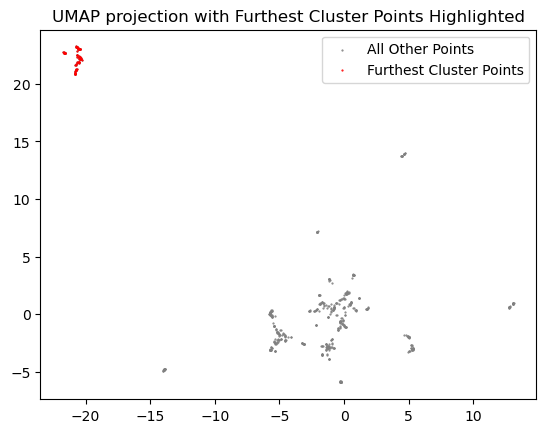

In [18]:
UMAP_highlight_selected_points(compounds)

  0%|          | 0/595 [00:00<?, ?it/s][11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPRECATION WARNING: please use MorganGenerator
[11:52:59] DEPREC

Number of noise points: 107


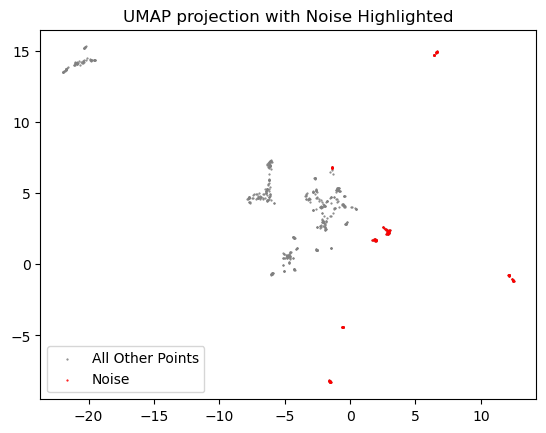

In [19]:
UMAP_highlight_noise_points(compounds)